In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import sys, os
sys.path.append(os.getcwd())

from generateEnvironment import GenerateEnvironment
from gmm_estimator import SolveProblem
import matplotlib as mpl
np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)

## Define the SEM 

In [2]:
connectivity_e0 = np.array([
    [0,0,0,0,0,0,0,0], # H / 0
    [0,0,0,0,0,0,0,0], # I / 1
    [2,0,0,0,0,0,0,0], # X_1 / 2
    [1,0,1,0,0,0,0,0], # X_2 / 3
    [0,0,-1,2,0,0,0,0], # X_3 / 4
    [0,0,1,0,1,0,0,0], # X_4 / 5
    [1,0,0,1,0,2,0,0], # Y / 6
    [0,0,0,2,0,1,-1,0], # X_5 / 7
])
x_indices=np.array([2,3,4,5,7])
y_index=6
n_samples=500
n_reps=500
alpha=0.05

## Simulations for a mix of constraint types

#### Tables 1 and 5

In [3]:
print('Table 1')
print(20*'=')
print('Causal Aggregation')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = [{2:{'type':'iv','iv_index':1}}]
        list_dict_interventions.append({i:{'type':'independent'} for i in [4,7]})
        list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_beta_GMM(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )
print(10*'-')
print('Pooled OLS')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = [{2:{'type':'iv','iv_index':1}}]
        list_dict_interventions.append({i:{'type':'independent'} for i in [4,7]})
        list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_pooled_beta_OLS(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

Table 1
Causal Aggregation
For n_samples 50: Avg coverage: 0.99 pm0.008899438184514795. Avg length: 387.8120381644023 pm585.5738085699246.
For n_samples 100: Avg coverage: 0.9856 pm0.010655567558792914. Avg length: 25.815990741010022 pm23.90365177714871.
For n_samples 200: Avg coverage: 0.98 pm0.01252198067399882. Avg length: 111.80569763230207 pm248.91639549125486.
For n_samples 500: Avg coverage: 0.9724 pm0.014652846822375507. Avg length: 0.5183751882740323 pm0.04146417291960207.
For n_samples 1000: Avg coverage: 0.9596 pm0.01761086937093112. Avg length: 0.32764727262246124 pm0.01119308297276077.
----------
Pooled OLS
For n_samples 50: Avg coverage: 0.3664 pm0.04309533988727783. Avg length: 0.3194128535280255 pm0.006930102088631045.
For n_samples 100: Avg coverage: 0.232 pm0.037754575881606724. Avg length: 0.2217308801493202 pm0.004673542290027349.
For n_samples 200: Avg coverage: 0.1384 pm0.030886299875511152. Avg length: 0.15657169508895263 pm0.003250521890628.
For n_samples 500: A

## Adding all known constraints

In [4]:
print('Table 5: row 1')
print(20*'=')
print('Causal Aggregation')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = [{2:{'type':'iv','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}}]
        list_dict_interventions.append({4:{'type':'independent'},7:{'type':'independent'}, 5:{'type':'parental','parental_index':[2,4]}})
        list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_beta_GMM(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

print(10*'-')
print('Pooled OLS')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = [{2:{'type':'iv','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}}]
        list_dict_interventions.append({4:{'type':'independent'},7:{'type':'independent'}, 5:{'type':'parental','parental_index':[2,4]}})
        list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_pooled_beta_OLS(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

Table 5: row 1
Causal Aggregation
For n_samples 50: Avg coverage: 0.9804 pm0.012398657991895734. Avg length: 1.7306921393741312 pm0.2517231333771732.
For n_samples 100: Avg coverage: 0.974 pm0.014233481654184262. Avg length: 1.1113519634497668 pm0.143177586242835.
For n_samples 200: Avg coverage: 0.9668 pm0.016024421362408066. Avg length: 0.6696332124802082 pm0.05809029347337898.
For n_samples 500: Avg coverage: 0.9664 pm0.016117329803661647. Avg length: 0.3839733119150821 pm0.022692931053089307.
For n_samples 1000: Avg coverage: 0.9628 pm0.016927175783337276. Avg length: 0.25590609345661003 pm0.011466345218796399.
----------
Pooled OLS
For n_samples 50: Avg coverage: 0.3664 pm0.04309533988727783. Avg length: 0.3166691516892051 pm0.006892852485880889.
For n_samples 100: Avg coverage: 0.2276 pm0.037501812222877975. Avg length: 0.2227105290912242 pm0.0046776579426490526.
For n_samples 200: Avg coverage: 0.1308 pm0.030158429667341766. Avg length: 0.15640203772647268 pm0.003248542313201542

## Sample only from randomized environment

In [5]:
print('Table 5: row 2')
print(20*'=')
print('Causal Aggregation')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = []
        list_dict_interventions.append({i:{'type':'independent'} for i in [2,3,4,5,7]})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_beta_GMM(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

print(10*'-')
print('Pooled OLS')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = []
        list_dict_interventions.append({i:{'type':'independent'} for i in [2,3,4,5,7]})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_pooled_beta_OLS(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

Table 5: row 2
Causal Aggregation
For n_samples 50: Avg coverage: 0.9504 pm0.019419544793841077. Avg length: 0.839605304485769 pm0.01309830270259702.
For n_samples 100: Avg coverage: 0.9484 pm0.019786346807836964. Avg length: 0.5758781318643683 pm0.005625716903837396.
For n_samples 200: Avg coverage: 0.9548 pm0.01858105702052496. Avg length: 0.3974539905837035 pm0.0026556639402034775.
For n_samples 500: Avg coverage: 0.952 pm0.019119832635250758. Avg length: 0.2492520995038436 pm0.0010237197037922935.
For n_samples 1000: Avg coverage: 0.952 pm0.019119832635250758. Avg length: 0.17589040981284357 pm0.000513078028940895.
----------
Pooled OLS
For n_samples 50: Avg coverage: 0.948 pm0.019858700863853104. Avg length: 0.831443234281712 pm0.011423403091782892.
For n_samples 100: Avg coverage: 0.948 pm0.019858700863853104. Avg length: 0.5702782925607517 pm0.005266039913329413.
For n_samples 200: Avg coverage: 0.9472 pm0.020002431852152374. Avg length: 0.3967453814228896 pm0.002501482434061734

## Additional fully randomized environment

In [6]:
print('Table 5: row 3')
print(20*'=')
print('Causal Aggregation')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = [{2:{'type':'iv','iv_index':1}}]
        list_dict_interventions.append({i:{'type':'independent'} for i in [4,7]})
        list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
        list_dict_interventions.append({i:{'type':'independent'} for i in [2,3,4,5,7]})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_beta_GMM(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

print(10*'-')
print('Pooled OLS')
for n_samples in np.array([50,100,200,500,1000]):
    coverage=[]
    length=[]
    for _ in np.arange(n_reps):
        list_dict_interventions = [{2:{'type':'iv','iv_index':1}}]
        list_dict_interventions.append({i:{'type':'independent'} for i in [4,7]})
        list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
        list_dict_interventions.append({i:{'type':'independent'} for i in [2,3,4,5,7]})
        solver = SolveProblem(connectivity_e0,x_indices,y_index)
        
        list_environments = [solver.generate_intervention(n_samples, dict_interventions)
                             for dict_interventions in list_dict_interventions]
        n_samples_tot = np.sum([env['dataset'].shape[1] for env in list_environments])
        
        ### Estimate beta_hat and aCov here
    
        beta_hat, aCov = solver.compute_pooled_beta_OLS(list_environments)
  
        ###
    
        CI = solver.compute_CI(beta_hat, aCov, n_samples_tot, alpha)
        
        for coord in np.arange(5):
            coverage.append((CI[0,coord]<solver.beta[coord])&
                        (CI[1,coord]>solver.beta[coord]))
            length.append(CI[1,coord]-CI[0,coord])
            
    print('For n_samples {}: Avg coverage: {} pm{}. Avg length: {} pm{}.'.format(n_samples,np.mean(coverage),2*np.std(coverage)/np.sqrt(n_reps),np.mean(length),2*np.std(length)/np.sqrt(n_reps))
         )

Table 5: row 3
Causal Aggregation
For n_samples 50: Avg coverage: 0.9256 pm0.023471623718865294. Avg length: 0.5537533247414088 pm0.010779943090039408.
For n_samples 100: Avg coverage: 0.9432 pm0.020702417250166708. Avg length: 0.3890863658431842 pm0.006177075861578655.
For n_samples 200: Avg coverage: 0.9568 pm0.01818433611655922. Avg length: 0.27836242550226903 pm0.004014274725773876.
For n_samples 500: Avg coverage: 0.9568 pm0.01818433611655922. Avg length: 0.17585311892754477 pm0.0022931958938911426.
For n_samples 1000: Avg coverage: 0.9532 pm0.018891217006852683. Avg length: 0.12452296288417242 pm0.0015830725302589596.
----------
Pooled OLS
For n_samples 50: Avg coverage: 0.3772 pm0.04335160066248996. Avg length: 0.27684371380268746 pm0.004232716482352132.
For n_samples 100: Avg coverage: 0.208 pm0.03630272717028295. Avg length: 0.19489807138464102 pm0.002826752890577924.
For n_samples 200: Avg coverage: 0.066 pm0.022207025915236826. Avg length: 0.1370046064184824 pm0.001896522957

## Scatter plots
#### Figures 6 and 8

In [7]:
list_dict_interventions=[]
list_dict_interventions.append({})
list_dict_interventions.append({i:{'type':'independent'} for i in [4,7]})
list_dict_interventions.append({3:{'type':'independent','iv_index':1}, 5:{'type':'parental','parental_index':[2,4]}})
solver = SolveProblem(connectivity_e0,x_indices,y_index)
list_environments = [solver.generate_intervention(1000, dict_interventions)
                     for dict_interventions in list_dict_interventions]

#### Scatterplot Figure 6

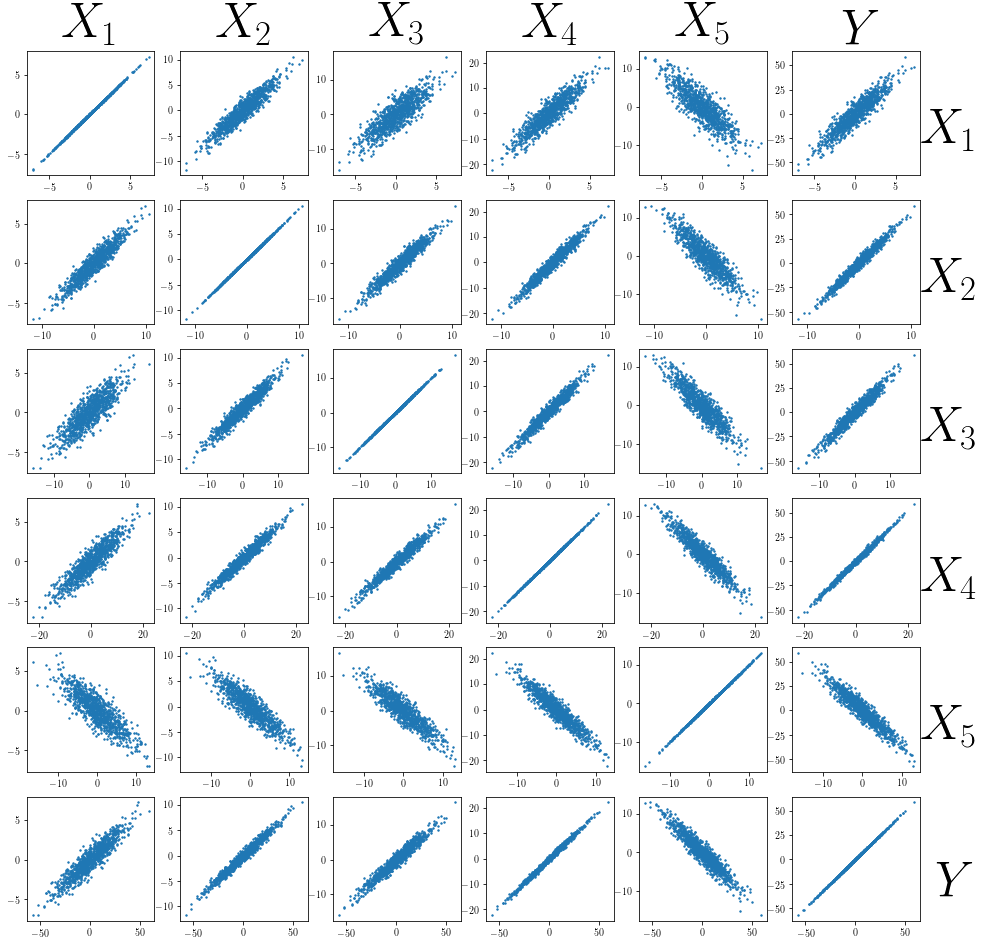

In [8]:
env_id=0
X=list_environments[env_id]['dataset'][x_indices,:]
Y=list_environments[env_id]['dataset'][y_index,:]
fig, ax = plt.subplots(nrows=len(x_indices)+1,ncols=len(x_indices)+1, figsize=(16,16))
for i,j in itertools.product(np.arange(len(x_indices)),repeat=2):
    _ = ax[i,j].scatter(X[i,:],X[j,:],s=2, rasterized=True)
for i in np.arange(len(x_indices)):
    _ = ax[len(x_indices),i].scatter(Y, X[i,:], s=2, rasterized=True)
    _ = ax[i,len(x_indices)].scatter(X[i,:], Y, s=2, rasterized=True)
    _ = ax[0,i].set_title('$X_{}$'.format(i+1), fontsize=50)
    _ = ax[i,len(x_indices)].yaxis.set_label_position("right")
    _ = ax[i,len(x_indices)].set_ylabel('$X_{}$'.format(i+1), rotation=360, labelpad=30, fontsize=50)
_ = ax[len(x_indices),len(x_indices)].scatter(Y, Y, s=2, rasterized=True)
_ = ax[0,5].set_title('$Y$', fontsize=50)
_ = ax[5,5].yaxis.set_label_position("right")
_ = ax[5,5].set_ylabel('$Y$', rotation=360, labelpad=30, fontsize=50)
_ = plt.savefig('scatter_{}.png'.format(env_id), format='png',bbox_inches='tight')

#### Scatterplot Figure 8 (left)

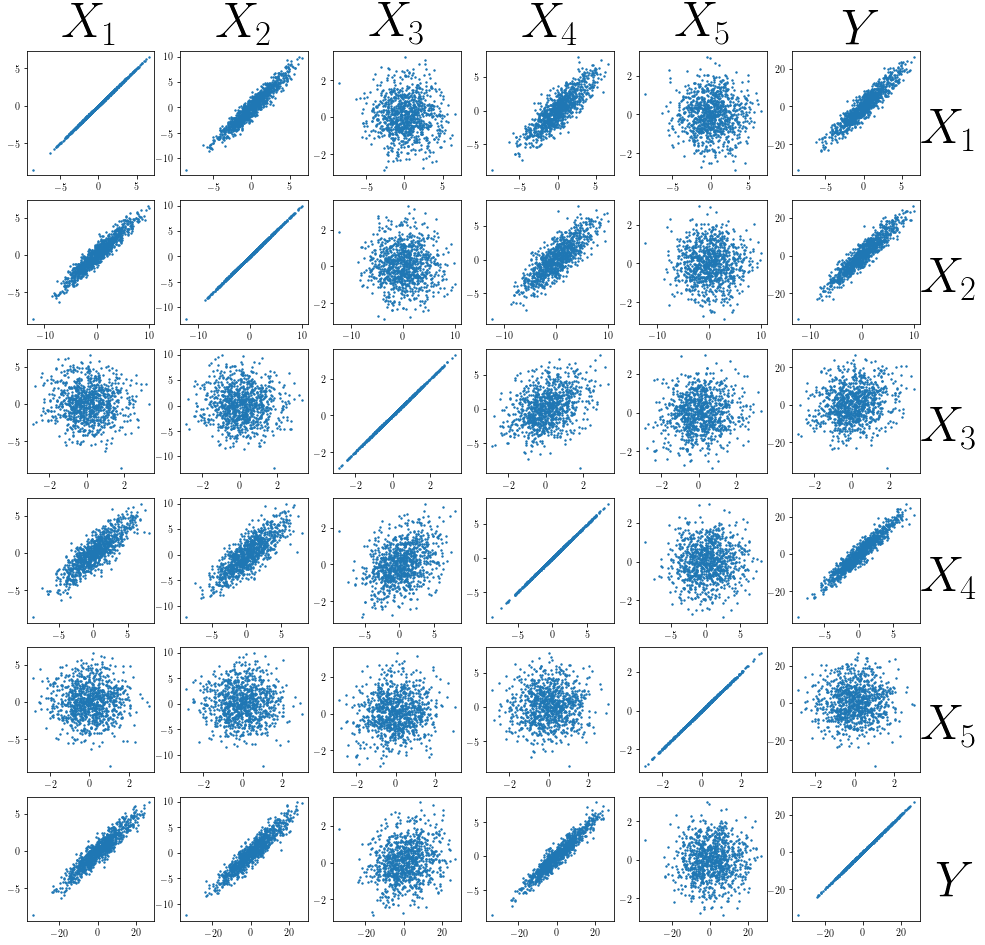

In [9]:
env_id=1
X=list_environments[env_id]['dataset'][x_indices,:]
Y=list_environments[env_id]['dataset'][y_index,:]
fig, ax = plt.subplots(nrows=len(x_indices)+1,ncols=len(x_indices)+1, figsize=(16,16))
for i,j in itertools.product(np.arange(len(x_indices)),repeat=2):
    _ = ax[i,j].scatter(X[i,:],X[j,:],s=2, rasterized=True)
for i in np.arange(len(x_indices)):
    _ = ax[len(x_indices),i].scatter(Y, X[i,:], s=2, rasterized=True)
    _ = ax[i,len(x_indices)].scatter(X[i,:], Y, s=2, rasterized=True)
    _ = ax[0,i].set_title('$X_{}$'.format(i+1), fontsize=50)
    _ = ax[i,len(x_indices)].yaxis.set_label_position("right")
    _ = ax[i,len(x_indices)].set_ylabel('$X_{}$'.format(i+1), rotation=360, labelpad=30, fontsize=50)
_ = ax[len(x_indices),len(x_indices)].scatter(Y, Y, s=2, rasterized=True)
_ = ax[0,5].set_title('$Y$', fontsize=50)
_ = ax[5,5].yaxis.set_label_position("right")
_ = ax[5,5].set_ylabel('$Y$', rotation=360, labelpad=30, fontsize=50)
_ = plt.savefig('scatter_{}.png'.format(env_id), format='png',bbox_inches='tight')

#### Scatterplot Figure 8 (right)

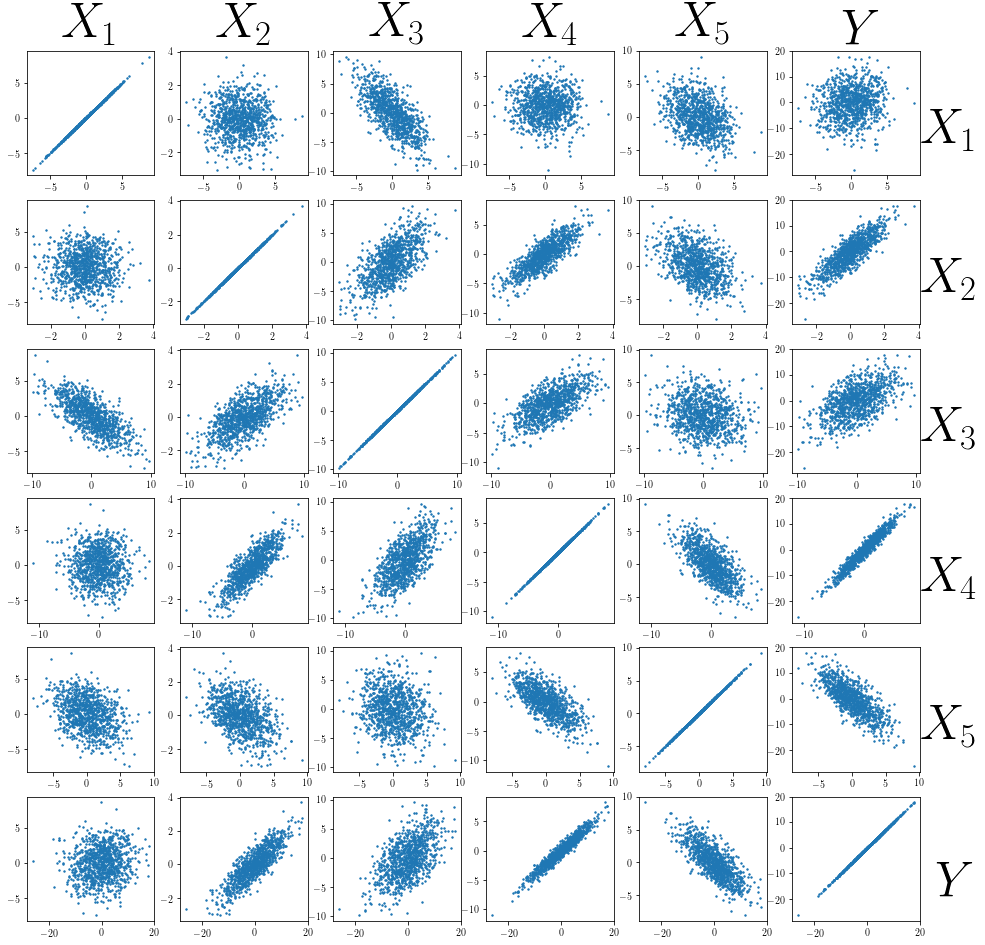

In [10]:
env_id=2
X=list_environments[env_id]['dataset'][x_indices,:]
Y=list_environments[env_id]['dataset'][y_index,:]
fig, ax = plt.subplots(nrows=len(x_indices)+1,ncols=len(x_indices)+1, figsize=(16,16))
for i,j in itertools.product(np.arange(len(x_indices)),repeat=2):
    _ = ax[i,j].scatter(X[i,:],X[j,:],s=2, rasterized=True)
for i in np.arange(len(x_indices)):
    _ = ax[len(x_indices),i].scatter(Y, X[i,:], s=2, rasterized=True)
    _ = ax[i,len(x_indices)].scatter(X[i,:], Y, s=2, rasterized=True)
    _ = ax[0,i].set_title('$X_{}$'.format(i+1), fontsize=50)
    _ = ax[i,len(x_indices)].yaxis.set_label_position("right")
    _ = ax[i,len(x_indices)].set_ylabel('$X_{}$'.format(i+1), rotation=360, labelpad=30, fontsize=50)
_ = ax[len(x_indices),len(x_indices)].scatter(Y, Y, s=2, rasterized=True)
_ = ax[0,5].set_title('$Y$', fontsize=50)
_ = ax[5,5].yaxis.set_label_position("right")
_ = ax[5,5].set_ylabel('$Y$', rotation=360, labelpad=30, fontsize=50)
_ = plt.savefig('scatter_{}.png'.format(env_id), format='png',bbox_inches='tight')